In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/decibelcooper/nngpt.git

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()

import logging
logging.basicConfig(
format="%(levelname)s %(funcName)s():%(lineno)i: %(message)s",
)

# Readout segmentation

In [3]:
import numpy as np
import random as rand
from scipy import spatial

# geometry parameters
height = 100
width = 100
# pad segmentation for 2-D readout
m = 90
n = 90

# build arrays mapping pads to channel numbers
pitch_y = height / m
pitch_x = width / n

pad_y = []
pad_x = []
pad_c = []
for i in range(0, m):
    for j in range(0, n):
        pad_y.append(height/2 - (i+0.5)*pitch_y)
        pad_x.append(width/2 - (j+0.5)*pitch_x)

        # First pad is y axis, or axis 0
        axis = (i+j)%2
        if axis == 0:
            pad_c.append(i)
        else:
            pad_c.append(m + j)

pad_y = np.array(pad_y)
pad_x = np.array(pad_x)
pad_c = np.array(pad_c)

# define nearest channel sample binning using native KDTree search
pad_tree = spatial.cKDTree(np.transpose([pad_x, pad_y]))
def chan_counts(xy, split=True, randomize=True):
    if randomize:
        np.random.shuffle(xy)

    # split the samples evenly between the anode and cathode
    if split:
        xy = xy[:len(xy)//2]
        
    _, pads = pad_tree.query(xy)
    pads, counts = np.unique(pads, return_counts=True)
    try:
        pads, counts = zip(*filter(lambda x: x[0] < len(pad_c), zip(pads, counts)))
        return zip(pad_c[list(pads)], counts)
    except ValueError:
        return []

# Tomography

In [4]:
import logging
import nngpt

logging.getLogger().setLevel(logging.INFO)

# initialize planar nonnegative gaussian process tomography
p = nngpt.Planar(
    m + n,
    chan_counts,
    m=100, n=100,
    sample_density=10000,
)

INFO _init_design():133: g integration time: 75.803
INFO _init_design():178: covariance matrix calculation time: 23.657


In [5]:
import logging
import nngpt
import matplotlib.pyplot as plt

def plot_tomo_for_samples(xy, name, n_std=4, seg_name='2-D'):
    logging.getLogger().setLevel(logging.INFO)

    xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
    q = p.bin_channels(xy_diff)
    img = p.tomo(q)
    mean, cov = p.get_mean_and_cov(img)
    true_img = p.bin_pixels(xy)
    true_mean, true_cov = p.get_mean_and_cov(true_img)

    print('Simulated channel input')
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()
    ax.plot(q)
    ax.set_xlabel('readout channel')
    ax.set_yscale('log')
    fig.savefig(f'{seg_name}_{name}_channel-response.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    print(f'True image with calculated {n_std}-sigma confidence ellipse')
    fig = nngpt.draw_tomo(
        true_img, p.width, p.height, colorbar=True,
        mean=[None], cov=[None],
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{name}_truth-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print(f'Reconstructed image with overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img, p.width, p.height, colorbar=True,
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        mean=[[mean]], cov=[[cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_reco-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print('Differences in the images and overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img-true_img, p.width, p.height, colorbar=True,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_diff-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Covariant Gaussian

INFO sample_normal():16: sampling time: 0.132
INFO add_diffusion():67: sampling time: 0.164
INFO bin_channels():59: binning time: 1.499
INFO tomo():41: tomography time: 3.293
INFO tomo():42: tomography iterations: 9
INFO tomo():43: unconstrained pixel count: 253
INFO bin_pixels():72: binning time: 0.650


Simulated channel input


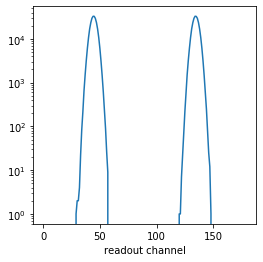

True image with calculated 4-sigma confidence ellipse


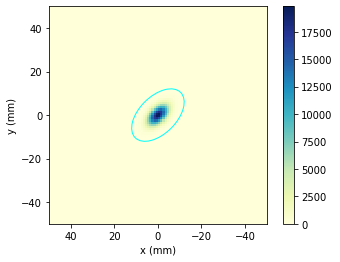

Reconstructed image with overlayed confidence ellipses


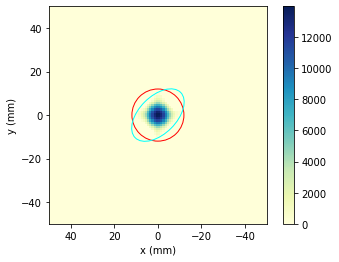

Differences in the images and overlayed confidence ellipses


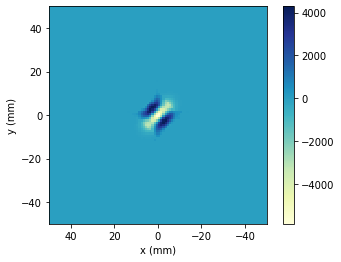

In [6]:
import nngpt
import numpy as np

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'cov-gauss')

## Two Gaussians

INFO sample_normal():16: sampling time: 0.191
INFO add_diffusion():67: sampling time: 0.235
INFO bin_channels():59: binning time: 3.155
INFO tomo():41: tomography time: 0.086
INFO tomo():42: tomography iterations: 10
INFO tomo():43: unconstrained pixel count: 394
INFO bin_pixels():72: binning time: 1.275


Simulated channel input


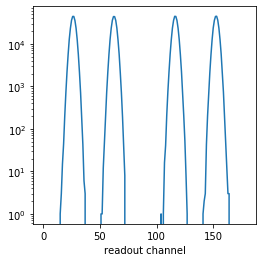

True image with calculated 4-sigma confidence ellipse


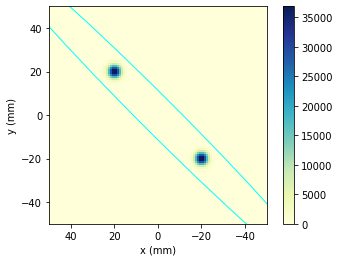

Reconstructed image with overlayed confidence ellipses


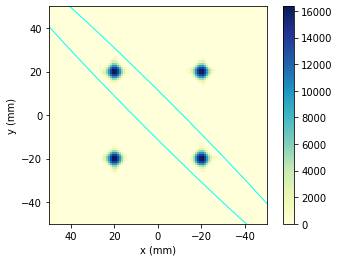

Differences in the images and overlayed confidence ellipses


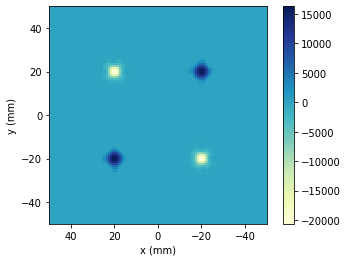

In [7]:
import nngpt
import numpy as np

means = 20*np.array([[1,1],[-1,-1]])
covs = 4*np.array([[[1,0],[0,1]],[[1,0],[0,1]]])
n_samples = [1e6,1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'double-gauss')

## Circle convolved with Gaussian

INFO sample_circle():33: sampling time: 1.679
INFO add_diffusion():67: sampling time: 1.000
INFO bin_channels():59: binning time: 15.823
INFO tomo():41: tomography time: 0.101
INFO tomo():42: tomography iterations: 12
INFO tomo():43: unconstrained pixel count: 1279
INFO bin_pixels():72: binning time: 6.904


Simulated channel input


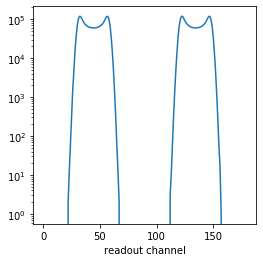

True image with calculated 4-sigma confidence ellipse


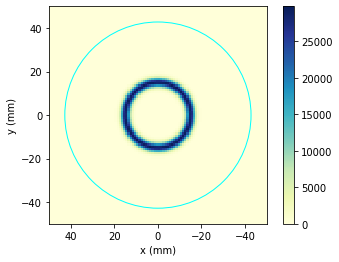

Reconstructed image with overlayed confidence ellipses


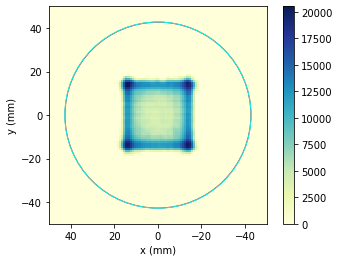

Differences in the images and overlayed confidence ellipses


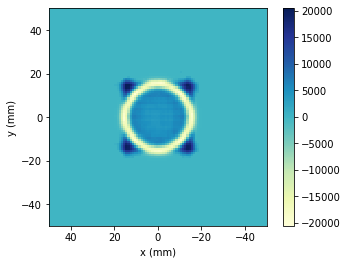

In [8]:
import nngpt

xy = nngpt.sample_circle()
plot_tomo_for_samples(xy, 'circle')

## Square convolved with Gaussian

INFO sample_square():54: sampling time: 1.158
INFO add_diffusion():67: sampling time: 1.165
INFO bin_channels():59: binning time: 15.961
INFO tomo():41: tomography time: 0.090
INFO tomo():42: tomography iterations: 12
INFO tomo():43: unconstrained pixel count: 907
INFO bin_pixels():72: binning time: 6.883


Simulated channel input


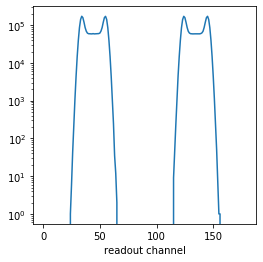

True image with calculated 4-sigma confidence ellipse


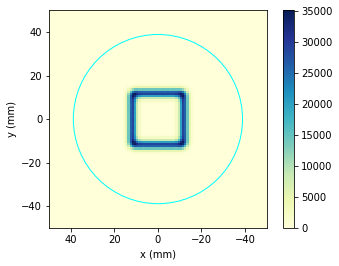

Reconstructed image with overlayed confidence ellipses


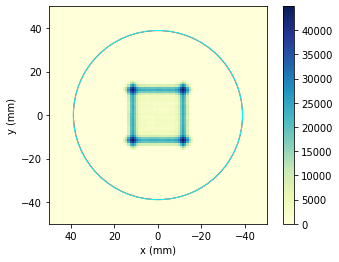

Differences in the images and overlayed confidence ellipses


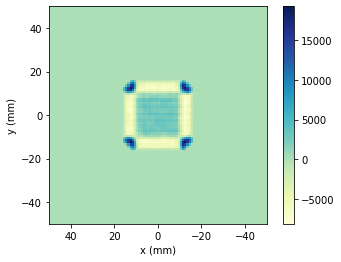

In [9]:
import nngpt

xy = nngpt.sample_square()
plot_tomo_for_samples(xy, 'square')

## Execution time benchmark using covariant Gaussian

In [10]:
import logging
import nngpt

logging.getLogger().setLevel(logging.ERROR)

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
q = p.bin_channels(xy_diff)

%timeit p.tomo(q, ret_pixels=False)

60.2 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
